In [2]:
import tango
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import time
Z = 1
X = 2
Y = 3

## Init the Shutter controlled by a Arduino Tango communication

In [2]:
#insert arduino serial port to initialize connection with arduino
Arduino_Shutter = tango.DeviceProxy("voxel/Arduino_Shutter/1")
print(Arduino_Shutter.state())
Arduino_Shutter.set_timeout_millis(10000)


ON


In [3]:
ArduinoInfo =   {
                    "Name"      : "AS1",
                    "COM"       : 4
                }
ArduinoInfo = json.dumps(ArduinoInfo)
Arduino_Shutter.Connect(ArduinoInfo)

'Device is connected'

## Init the SMC100 Tango communication

In [52]:
#insert motors' serial port to initialize connection with motors
SMC100 = tango.DeviceProxy("voxel/SMC100/1")
print(SMC100.state())
SMC100.set_timeout_millis(50000)

ON


In [53]:
userInfoController =  {
                            "Name"                  : "SC1",
                            "COM"                   : 5,
                            "Number_of_controllers" : 3
                        }
userInfoController=json.dumps(userInfoController)
SMC100.ConnectCamera(userInfoController)

'Controller has been connected successfully COM5'

## Init the Thorlabs Camera Tango communication

In [3]:
ThorlabsCamera =  tango.DeviceProxy("camera/thorlabs/zelux44")
print(ThorlabsCamera.state())
ThorlabsCamera.set_timeout_millis(9000)

RUNNING


In [4]:
ThorlabsCamera.StartAcqusition()

''

In [5]:
ThorlabsCamera.StopAcqusition()

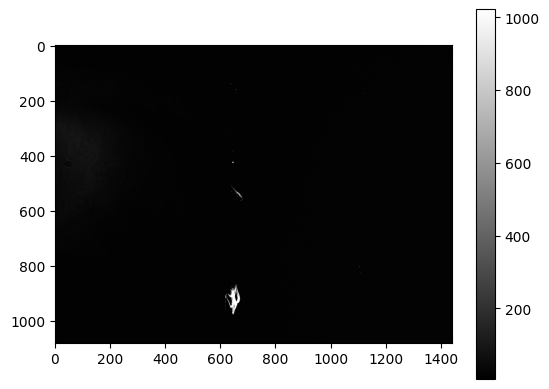

In [4]:
ThorlabsCamera.Snap()
plt.imshow(ThorlabsCamera.Image,cmap="grey")
plt.colorbar()

### Function that recives the Coord and send it to te Controller via Tango

In [64]:
def MoveToPosition(coords):
    userInfoP = {
                    "Name" : "SC1",
                    "Axis" : X
                }
    userInfoP_String = json.dumps(userInfoP)
    current_position_x = SMC100.GetPosition(userInfoP_String)
    print("Position X:"+str(current_position_x))
    userInfoP["Axis"] = Y
    userInfoP_String = json.dumps(userInfoP)
    current_position_y = SMC100.GetPosition(userInfoP_String)
    print("Position Y:"+str(current_position_x))
    userInfoP["Axis"] = Z
    userInfoP_String = json.dumps(userInfoP)
    current_position_z = SMC100.GetPosition(userInfoP_String)
    print("Position Z:"+str(current_position_x))

    # print(current_position_x)
    # print(current_position_y)

    userInfoMA =    {
                        "Name"              : "SC1",
                        "Axis"              : Z,
                        "Position"          : 5,
                        "Wait_to_finish"    : False
                    }
    print(len(coords))
    if len(coords) == 3:
        if coords[0] != current_position_x:
            userInfoMA["Axis"] = X
            userInfoMA["Position"] = coords[0]
            userInfoMA_string = json.dumps(userInfoMA)
            SMC100.MoveAbsolute_mm(userInfoMA_string)

        if coords[1] != current_position_y:
            
            userInfoMA["Axis"] = Y
            userInfoMA["Position"] = coords[1]
            userInfoMA_string = json.dumps(userInfoMA)
            SMC100.MoveAbsolute_mm(userInfoMA_string)
        
        if coords[2] != current_position_z:
            
            userInfoMA["Axis"] = Z
            userInfoMA["Position"] = coords[2]
            userInfoMA_string = json.dumps(userInfoMA)
            SMC100.MoveAbsolute_mm(userInfoMA_string)

        # elif coords[0]!=current_position_x and coords[1]!=current_position_y:
        #     userInfoMA["Wait_to_finish" ] = False
        #     userInfoMA["Axis"] = Y
        #     userInfoMA["Position"] = coords[1]
        #     userInfoMA_string = json.dumps(userInfoMA)
        #     SMC100.MoveAbsolute_mm(userInfoMA_string)
        #     userInfoMA["Axis"] = X
        #     userInfoMA["Position"] = coords[0]
        #     userInfoMA_string = json.dumps(userInfoMA)
        #     SMC100.MoveAbsolute_mm(userInfoMA_string)

    else:
        print("Error: Wrong input. Please insert a position to which you want to move as x, y, z",
            "(e.g. the input of 1.2, 3.3 will move the motors to a position where x=1.2 mm and y=3.3 mm)")

Simple test of the movement of the motors 

In [66]:
#run to make a move to a desired position

a = input("insert a desired position [mm] as a pair x, y, z: ") 
coords = list(float(x) for x in a.split(","))
MoveToPosition(coords)


Position X:19.99999
Position Y:19.99999
Position Z:19.99999
3


In [40]:
ThorlabsCamera.get_command_list()

['ConnectCamera', 'DisconnectCam', 'GetDataPhoto', 'GetPhotoJSON', 'Init', 'ListCameras', 'SetExposureTimeUS', 'SetFramesPerTriggerZeroForUnlimited', 'SetGain', 'SetImagePollTimeoutMS', 'SetRoi', 'State', 'Status', 'TakePhoto']

In [68]:
timeUS = {"CamName":"C1",
       "exposure_time_us": 50000}
timeUS_string = json.dumps(timeUS)
ThorlabsCamera.SetExposureTimeUS(timeUS_string)

'CAMS  was set exposure time 50000 us\n'

The experiment code 

In [32]:
#insert desired values for time_s, list_of_points and movement_distance to move motors and make holes (open shutter) in a desired pattern

#insert the amount of time [s] for the shutter to remain open
time_s = float(0.0010)
#insert coordinates of desired positions [mm] as a list of pairs [[x1,y1],[x2,y2],...], e.g.[[6,6], [4,6.5], [2.5,8]]: "
list_of_points = [[17,20,10], [16.5,20.5,10], [16,19,10] ]#, [2,10], [2.53,12], [4,13.46], [6,14], [8,13.46], [9.46,12], [10,10], [9.46,8], [8,6.53]]
#insert the maximum distance in one of the dimensions (x or y) between two of the neighbouring points
movement_distance = 2

Image_saved =[]

userInfoMTA = {
                    "Name"              : "SC1",
                    "Axis"              : X,
                    "Position"          : movement_distance
                    }
Device_to_Open =    {
                        "Name"      : "AS1"
                    }
Device_to_Open_string = json.dumps(Device_to_Open)

for coords in list_of_points:

    userInfoMTA["Position"] = movement_distance
    userInfoMTA_string = json.dumps(userInfoMTA)

    time_to_wait_move = float(SMC100.GetMotionTimeForRelativeMove(userInfoMTA_string))
    
    MoveToPosition(coords)
    time.sleep(time_to_wait_move)
    # this closes and opens the shutter for time_s secs
    
    # image = json.loads(ThorlabsCamera.GetPhotoJSON("C1"))
    #ThorlabsCamera.TakePhoto("C1")
    # Arduino_Shutter.OpenShutter(Device_to_Open_string)
    # time.sleep(time_s)
    # Arduino_Shutter.CloseShutter(Device_to_Open_string)
    #image = json.loads(ThorlabsCamera.GetDataPhoto("C1"))
    # Image_saved.append(image["Image"])

DevFailed: DevFailed[
DevError[
    desc = KeyError: 'SC1'
           
  origin = Traceback (most recent call last):
  File "C:\Users\Voxel\Desktop\Tango_Device\Tango-Newport_SMC100\tango-env\Lib\site-packages\tango\server.py", line 1552, in cmd
    return get_worker().execute(f, self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Voxel\Desktop\Tango_Device\Tango-Newport_SMC100\tango-env\Lib\site-packages\tango\green.py", line 113, in execute
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Voxel\Desktop\Tango_Device\Tango-Newport_SMC100\SMC100.py", line 210, in GetMotionTimeForRelativeMove
    time_for_move = self.Controllers[uIMTR["Name"]].get_motion_time_for_relative_move(uIMTR["Axis"],uIMTR["Position"])
                    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: 'SC1'

  reason = PyDs_PythonError
severity = ERR]

DevError[
    desc = Failed to execute command_inout on device voxel/smc100/1, command GetMotionTimeForRelativeMove
  origin = class Tango::DeviceData __cdecl Tango::Connection::command_inout(const class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > &,const class Tango::DeviceData &) at (C:\GitLab-Runner\builds\tango-controls\cppTango\src\client\devapi_base.cpp:1334)
  reason = API_CommandFailed
severity = ERR]
]

3


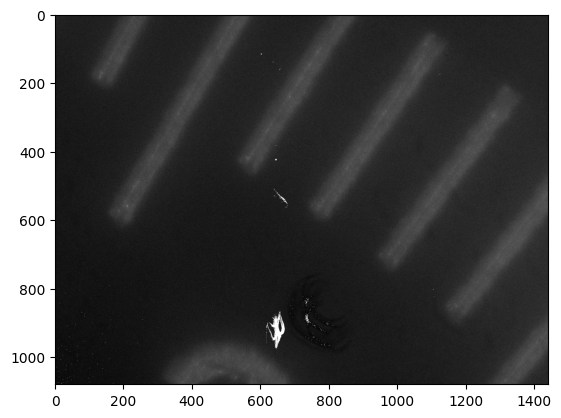

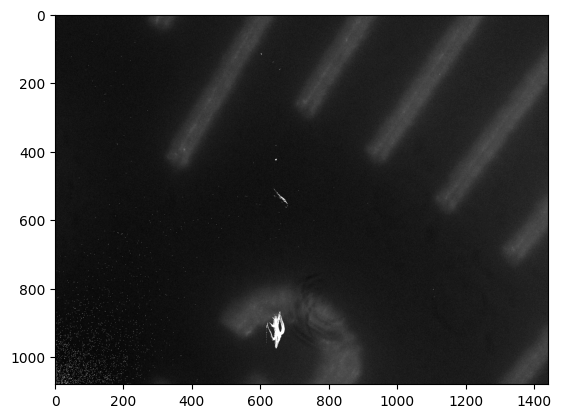

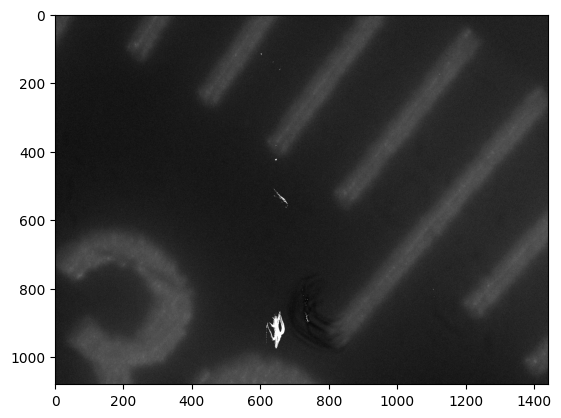

In [38]:
print(len(Image_saved))
plt.imshow(Image_saved[0],cmap="grey")
plt.show()
plt.imshow(Image_saved[1],cmap="grey")
plt.show()
plt.imshow(Image_saved[2],cmap="grey")
plt.show()

### Returning the motor to the Home position

In [67]:
userInfoH = {
                        "Name"              : "SC1",
                        "Axis"              : 1,
                        "Wait_to_finish"    : False
            } 
for i in range(1,4):
    print("Home motor",str(i))
    userInfoH["Axis"] = i
    userInfoH_string = json.dumps(userInfoH)
    SMC100.Home(userInfoH_string)

Home motor 1
Home motor 2
Home motor 3
